## Drop Out Prediction Models
Here we will predict whether a student will drop out or not. We can think of this as a classification problem. Where we will try different models and investigate which one of them performs better. The idea of this is to see if we can incorporate a functionality to raise a warning for students who are in danger of droping out.

---
Import the dataset and split the data into training and validation set, as well as the year for which we want to make the predictions:

In [292]:
from DATASET import clean_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = clean_df.copy()
df = df.dropna(subset=['nota_assignatura'])

# Separate current year data (to predict)
df_train = df[df['curs_academic'] != '2021/22'].copy()
df_pred_target = df[df['curs_academic'] == '2021/22'].copy()

In [293]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define target variable (abandonament) and input features (droping target from features)
X_train_full = df_train.drop(columns=['abandonament'])
y_train_full = df_train['abandonament']

# Split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

# Data to predict
X_test = df_pred_target.drop(columns=['abandonament'])
y_test = df_pred_target['abandonament']   # Ground truth for 2023/24

# Select categorical columns to encode
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

Define some functions to evaluate the models and plot results:

In [294]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_classification_models(model, X_test, y_test):

    y_pred = model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_classification_results(y_true, y_pred, y_proba=None, labels=None):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=labels, yticklabels=labels)
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC Curve (if probabilities provided)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('Receiver Operating Characteristic')
        axes[1].legend(loc='lower right')
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [296]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def cross_validation(pipeline, X_train, y_train, scoring='f1', cv=5, random_state=42):
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=stratified_cv)
    print("Cross-validated F1 scores:", scores)
    print("Mean F1:", scores.mean())

Let's plot the distribution of our classes to understand the data we are dealing with:

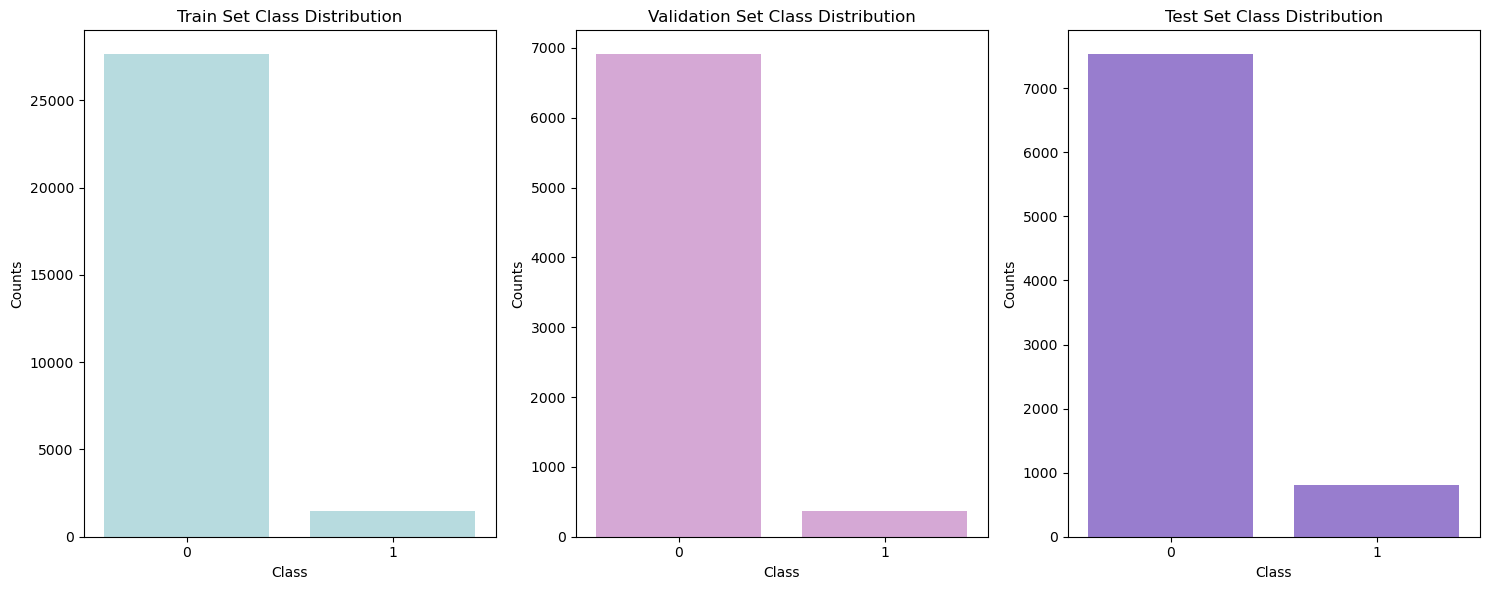

In [297]:
# Compute class distributions
data_train = {'0': np.sum(y_train == 0), '1': np.sum(y_train == 1)}
data_val   = {'0': np.sum(y_val == 0), '1': np.sum(y_val == 1)}
data_test  = {'0': np.sum(y_test == 0), '1': np.sum(y_test == 1)}

# Create DataFrames
df_train = pd.DataFrame({'Class': ['0', '1'], 'Counts': [data_train['0'], data_train['1']]})
df_val   = pd.DataFrame({'Class': ['0', '1'], 'Counts': [data_val['0'], data_val['1']]})
df_test  = pd.DataFrame({'Class': ['0', '1'], 'Counts': [data_test['0'], data_test['1']]})

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6))  

sns.barplot(data=df_train, x='Class', y='Counts', color='powderblue', ax=axes[0])
axes[0].set_title("Train Set Class Distribution")

sns.barplot(data=df_val, x='Class', y='Counts', color='plum', ax=axes[1])
axes[1].set_title("Validation Set Class Distribution")

sns.barplot(data=df_test, x='Class', y='Counts', color='mediumpurple', ax=axes[2])
axes[2].set_title("Test Set Class Distribution")

plt.tight_layout()
plt.show()


As we can see the classes are not evenly distributed, we have much more negative cases than positive ones, both in training and validation sets, and we do not have any positive samples on the test set (the one for which we want to make the predictions).

---
### 1. Logistic Regression Model
---

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6907
           1       0.86      1.00      0.93       366

    accuracy                           0.99      7273
   macro avg       0.93      0.99      0.96      7273
weighted avg       0.99      0.99      0.99      7273



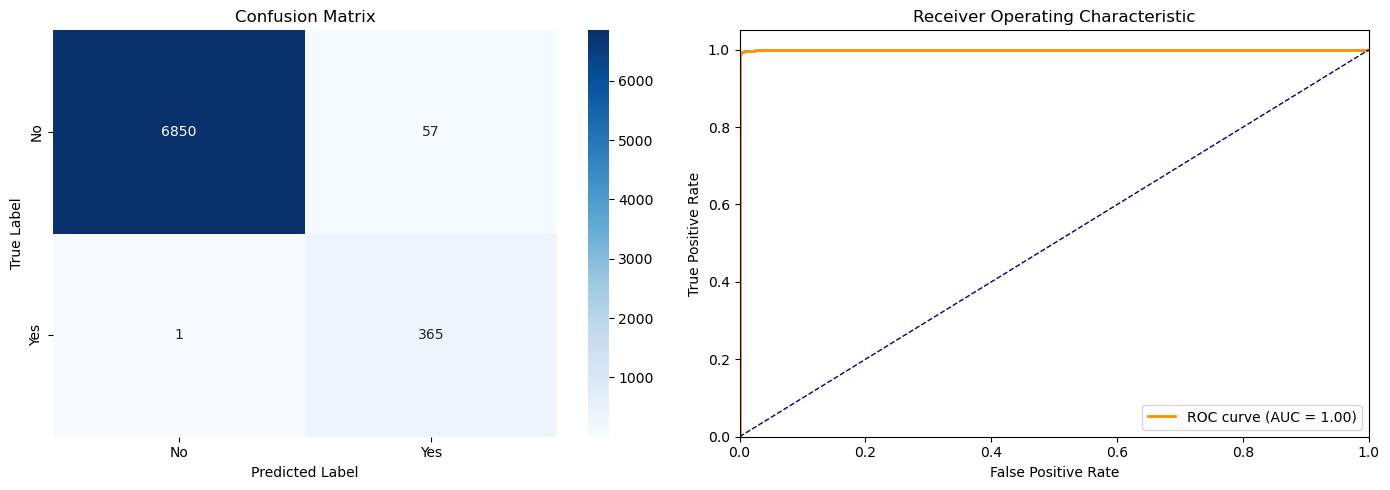

Cross-validated F1 scores: [0.9001233  0.93846154 0.90482077 0.90594059 0.90298507]
Mean F1: 0.9104662556176647


In [298]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline with Logistic Regression
LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=200, class_weight='balanced'))  
])

# Train the model
LR_pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = LR_pipeline.predict(X_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

y_pred = LR_pipeline.predict(X_val)
y_proba = LR_pipeline.predict_proba(X_val)[:, 1]  # Probabilities for positive class

# Plot confusion matrix as well as ROC-curve
plot_classification_results(y_val, y_pred, y_proba, labels=['No', 'Yes'])

# Use cross validation
cross_validation(LR_pipeline, X_train_full, y_train_full)

Now we will try using oversampling with the same model in order to see if it works better to reduce this problem:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6907
           1       0.96      1.00      0.98       366

    accuracy                           1.00      7273
   macro avg       0.98      1.00      0.99      7273
weighted avg       1.00      1.00      1.00      7273



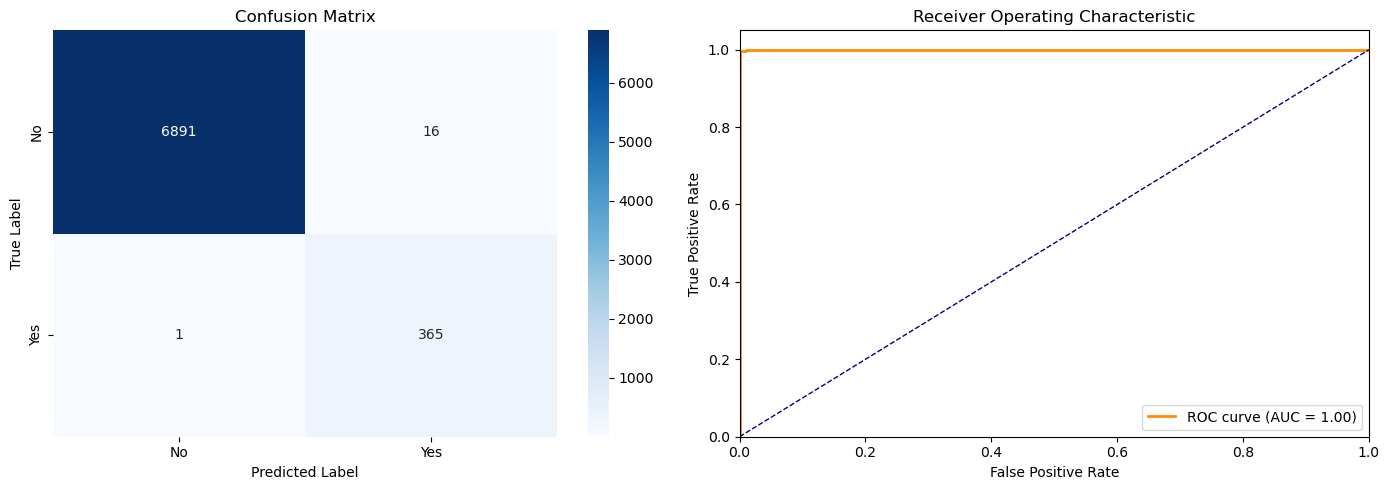

Cross-validated F1 scores: [0.96560847 0.98255034 0.96953642 0.95811518 0.95400788]
Mean F1: 0.9659636585257498


In [299]:
from imblearn.pipeline import Pipeline  
from imblearn.over_sampling import RandomOverSampler
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Define the pipeline with oversampling
LR_pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
LR_pipeline2.fit(X_train, y_train)

# Predict on validation set
y_pred = LR_pipeline2.predict(X_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

y_pred = LR_pipeline2.predict(X_val)
y_proba = LR_pipeline2.predict_proba(X_val)[:, 1]  # Probabilities for positive class

# Plot confusion matrix as well as ROC-curve
plot_classification_results(y_val, y_pred, y_proba, labels=['No', 'Yes'])

# Use cross validation
cross_validation(LR_pipeline2, X_train_full, y_train_full)

As we can see, both models are overfitting, with almost a perfect confusion matrix and ROC curve. They also perform well on cross validation but we need to take into account that we are using stratified K-fold cross validation, which means that all folds have a similar distribution (it is important to note that even though we tried using regularization, it did not seem to have positive effects on the performance of the models).

Now we will see how they perform on the test set:

#### Evaluation of model 1 on the test set:
For the first model we did not apply Over Sampling before, but we used the parameter `class_weight` to give more importance to errors on the minority class: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7528
           1       1.00      0.63      0.77       802

    accuracy                           0.96      8330
   macro avg       0.98      0.81      0.88      8330
weighted avg       0.97      0.96      0.96      8330



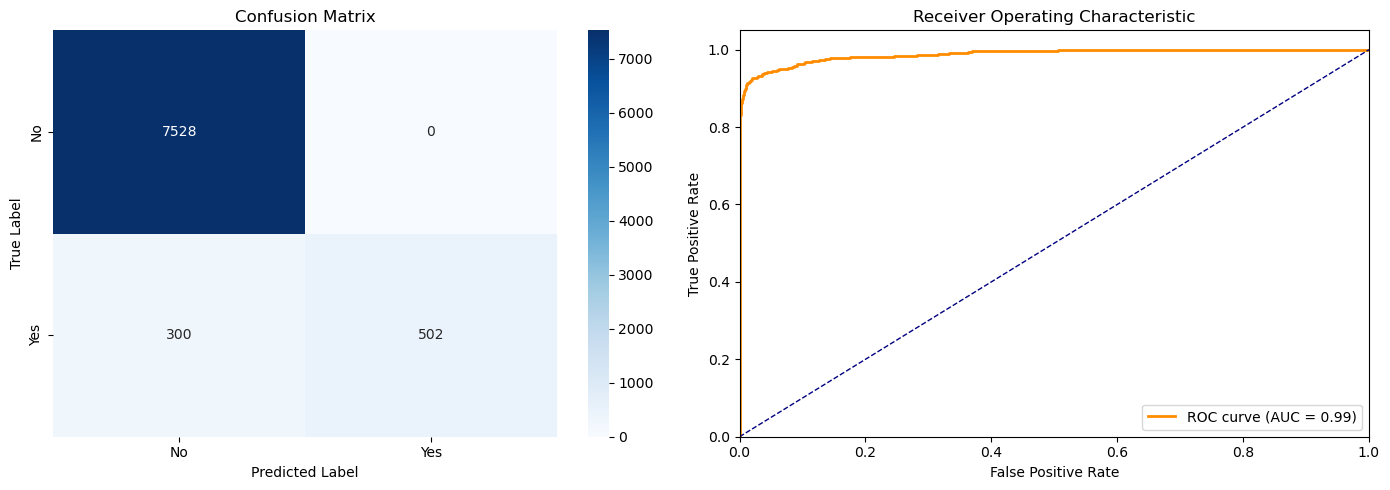

Cross-validated F1 scores: [0.9001233  0.93846154 0.90482077 0.90594059 0.90298507]
Mean F1: 0.9104662556176647


In [300]:
# Predict on test set
y_pred = LR_pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

y_pred = LR_pipeline.predict(X_test)
y_proba = LR_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Plot confusion matrix as well as ROC-curve
plot_classification_results(y_test, y_pred, y_proba, labels=['No', 'Yes'])

# Use cross validation
cross_validation(LR_pipeline, X_train_full, y_train_full)

#### Evaluation of model 2 on the test set:
For this second model we did not use `class_weight` since we performed Over Sampling before, in order to increase the number of positive samples in our dataset.

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7528
           1       1.00      0.66      0.79       802

    accuracy                           0.97      8330
   macro avg       0.98      0.83      0.89      8330
weighted avg       0.97      0.97      0.96      8330



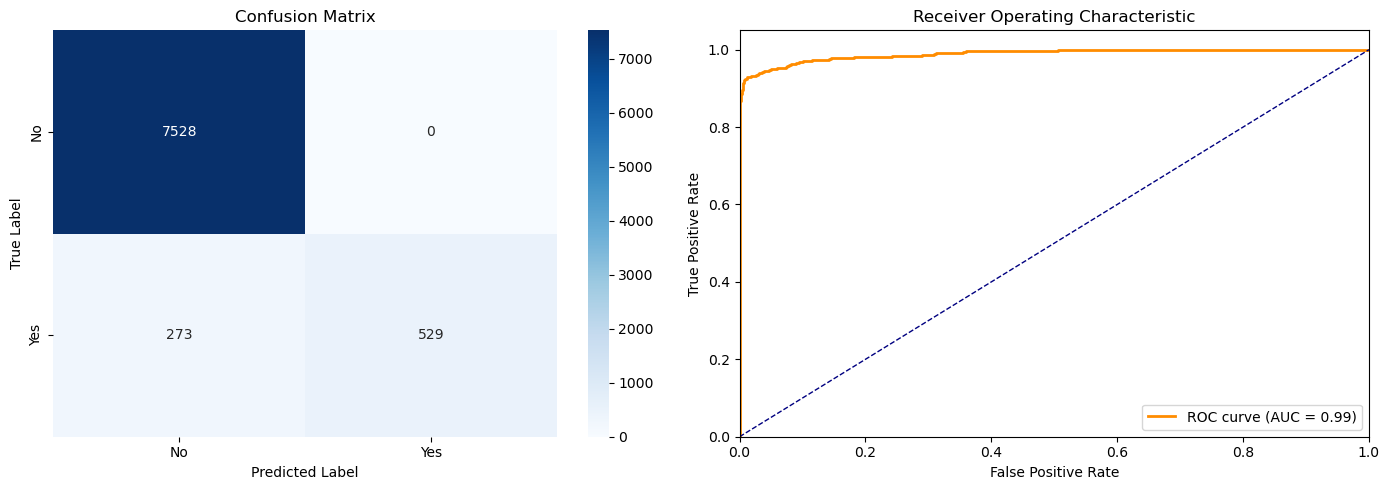

Cross-validated F1 scores: [0.96560847 0.98255034 0.96953642 0.95811518 0.95400788]
Mean F1: 0.9659636585257498


In [301]:
# Predict on test set
y_pred = LR_pipeline2.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

y_pred = LR_pipeline2.predict(X_test)
y_proba = LR_pipeline2.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Plot confusion matrix as well as ROC-curve
plot_classification_results(y_test, y_pred, y_proba, labels=['No', 'Yes'])

# Use cross validation
cross_validation(LR_pipeline2, X_train_full, y_train_full)

The results show that, between both models, the better performing one was, this last one, in which we applied Over Sampling first.

---
### 2. SVM: Support Vector Machine
---

SVM model without perfoming Over Sampling

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6907
           1       0.99      0.86      0.92       366

    accuracy                           0.99      7273
   macro avg       0.99      0.93      0.96      7273
weighted avg       0.99      0.99      0.99      7273



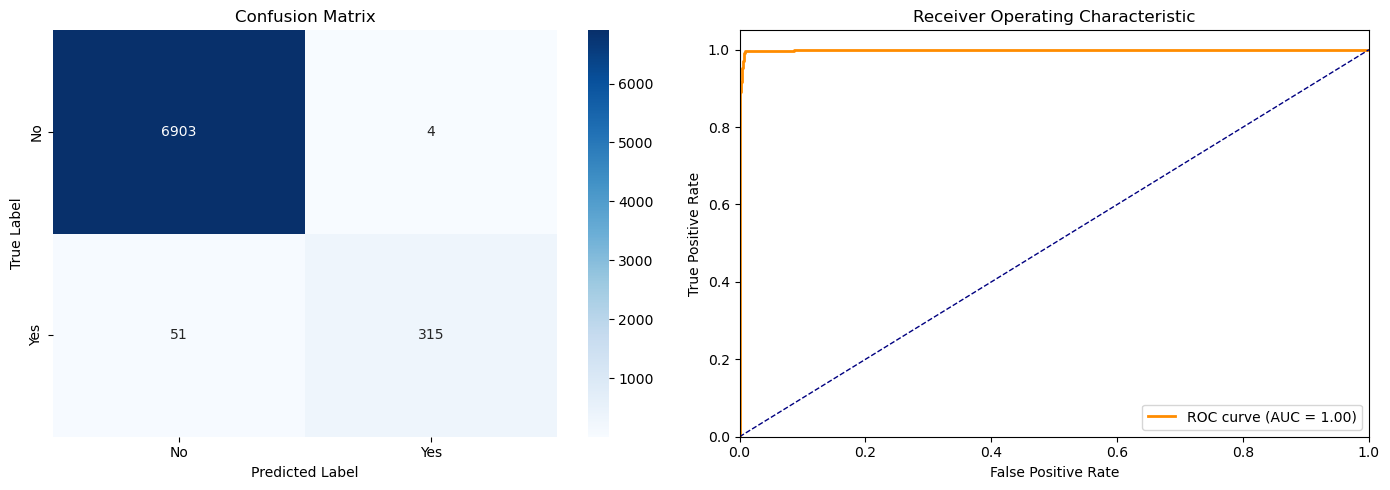

Cross-validated F1 scores: [0.93352192 0.95454545 0.94050992 0.92786421 0.92532943]
Mean F1: 0.9363541874326463


In [302]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Define the pipeline with preprocessing and SVM classifier
SVM_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # your preprocessing pipeline
    ('classifier', SVC())             # default kernel='rbf', probability=False
])

# Train the model
SVM_pipeline.fit(X_train, y_train)

# Predict labels on validation set
y_pred = SVM_pipeline.predict(X_val)

print("SVM model without perfoming Over Sampling\n")

# Evaluate performance
print(classification_report(y_val, y_pred))

# Get decision function scores for ROC curve
y_scores = SVM_pipeline.decision_function(X_val)

# Plot confusion matrix + ROC curve using your plotting function
plot_classification_results(y_val, y_pred, y_scores, labels=['No', 'Yes'])

cross_validation(SVM_pipeline, X_train_full, y_train_full)

SVM model perfoming Over Sampling

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6907
           1       0.98      0.99      0.99       366

    accuracy                           1.00      7273
   macro avg       0.99      1.00      0.99      7273
weighted avg       1.00      1.00      1.00      7273



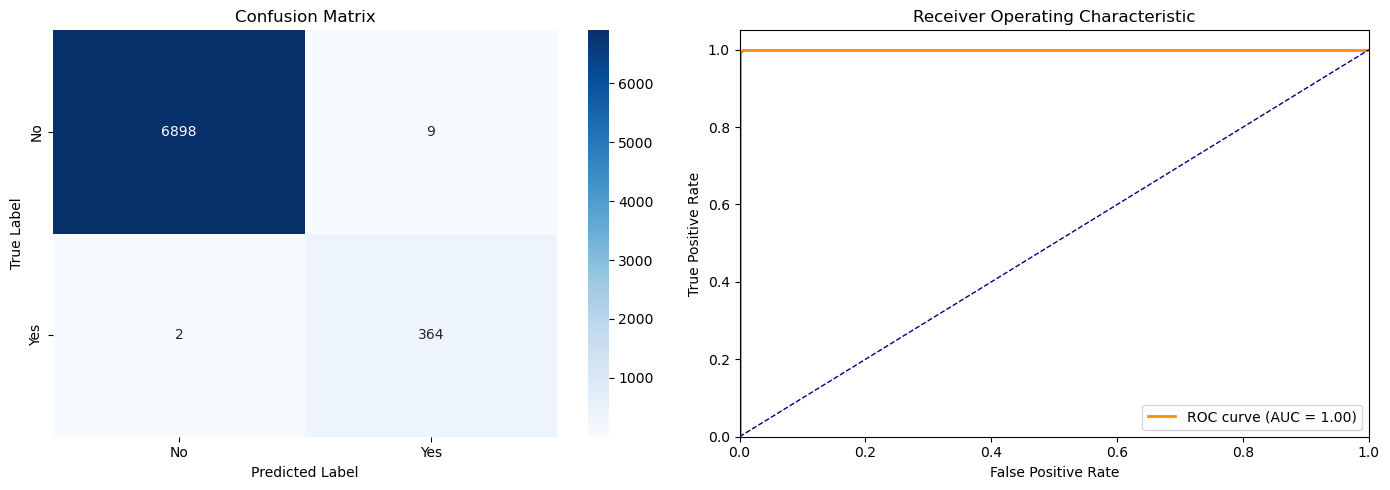

Cross-validated F1 scores: [0.9811828  0.99455041 0.98255034 0.9811828  0.99319728]
Mean F1: 0.986532722919846


In [303]:
from imblearn.pipeline import Pipeline

# Define the pipeline with oversampling
SVM_pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', SVC())
])

# Train the model
SVM_pipeline2.fit(X_train, y_train)

# Predict labels on validation set
y_pred = SVM_pipeline2.predict(X_val)

print("SVM model perfoming Over Sampling\n")

# Evaluate performance
print(classification_report(y_val, y_pred))

# Get decision function scores for ROC curve
y_scores = SVM_pipeline2.decision_function(X_val)

# Plot confusion matrix + ROC curve using your plotting function
plot_classification_results(y_val, y_pred, y_scores, labels=['No', 'Yes'])

cross_validation(SVM_pipeline2, X_train_full, y_train_full)

#### Evaluation of model 1 on the test set:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7528
           1       1.00      0.43      0.60       802

    accuracy                           0.95      8330
   macro avg       0.97      0.72      0.79      8330
weighted avg       0.95      0.95      0.94      8330



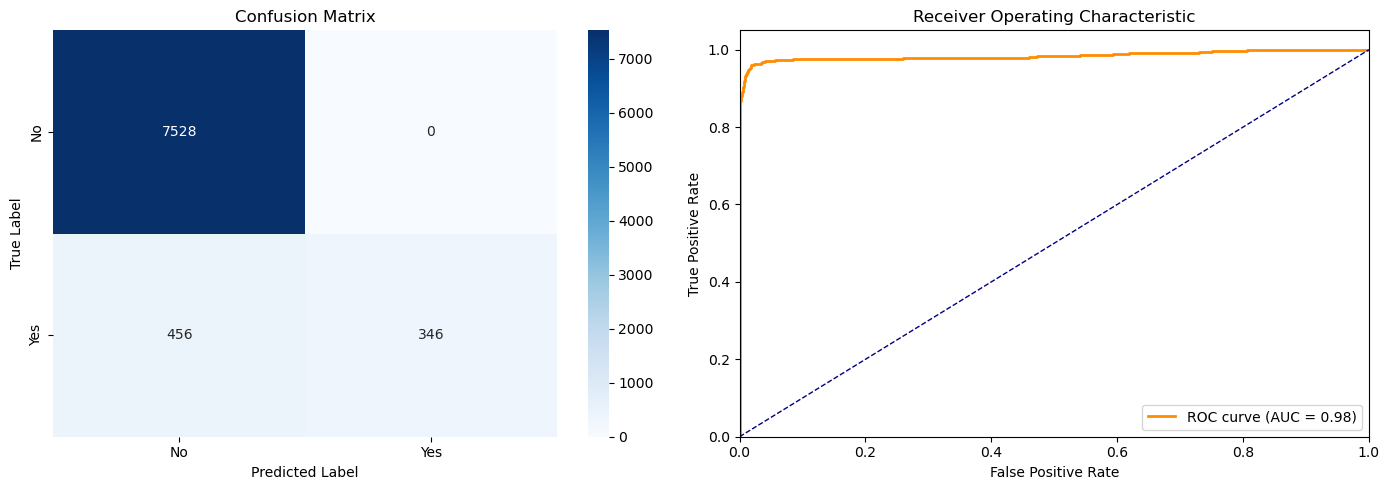

Cross-validated F1 scores: [0.93352192 0.95454545 0.94050992 0.92786421 0.92532943]
Mean F1: 0.9363541874326463


In [304]:
# Predict on test set
y_pred = SVM_pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

y_pred = SVM_pipeline.predict(X_test)
y_proba = SVM_pipeline.decision_function(X_test)  

# Plot confusion matrix as well as ROC-curve
plot_classification_results(y_test, y_pred, y_proba, labels=['No', 'Yes'])

# Use cross validation
cross_validation(SVM_pipeline, X_train_full, y_train_full)

#### Evaluation of model 2 on the test set

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7528
           1       1.00      0.64      0.78       802

    accuracy                           0.97      8330
   macro avg       0.98      0.82      0.88      8330
weighted avg       0.97      0.97      0.96      8330



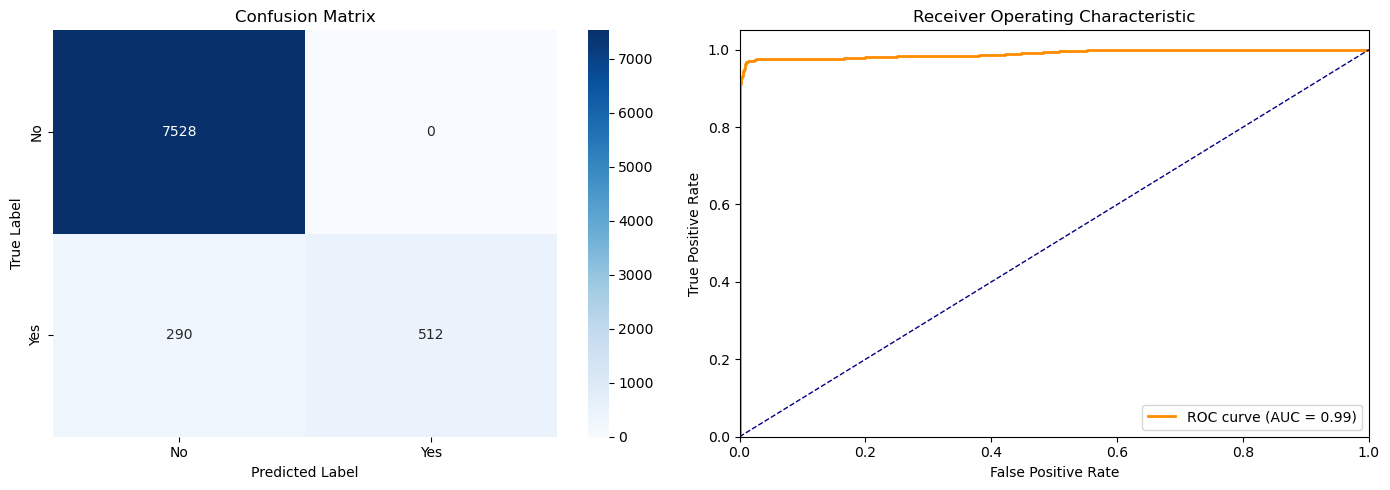

Cross-validated F1 scores: [0.9811828  0.99455041 0.98255034 0.9811828  0.99319728]
Mean F1: 0.986532722919846


In [305]:
# Predict on test set
y_pred = SVM_pipeline2.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

y_pred = SVM_pipeline2.predict(X_test)
y_proba = SVM_pipeline2.decision_function(X_test)  

# Plot confusion matrix as well as ROC-curve
plot_classification_results(y_test, y_pred, y_proba, labels=['No', 'Yes'])

# Use cross validation
cross_validation(SVM_pipeline2, X_train_full, y_train_full)

The results align with the previously observed pattern: the SVM classifier with oversampling outperforms the SVM without oversampling. However, even though providing good results, the SVM with oversampling, still had more false negatives than the Logistic Regression model with oversampling.

---
### 3. Random Forest

*Random Forest is a powerful machine learning model. It combines many decision trees to make better and more stable predictions. It works well even with messy or missing data, and it's good at handling both classification and regression problems. In addition, it helps reduce the risk of overfitting compared to a single decision tree.*

---

For this particular case we will directly use oversampling

In [306]:
# No need to scale features for Random
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      6907
           1       0.17      0.84      0.28       366

    accuracy                           0.78      7273
   macro avg       0.58      0.81      0.58      7273
weighted avg       0.95      0.78      0.84      7273



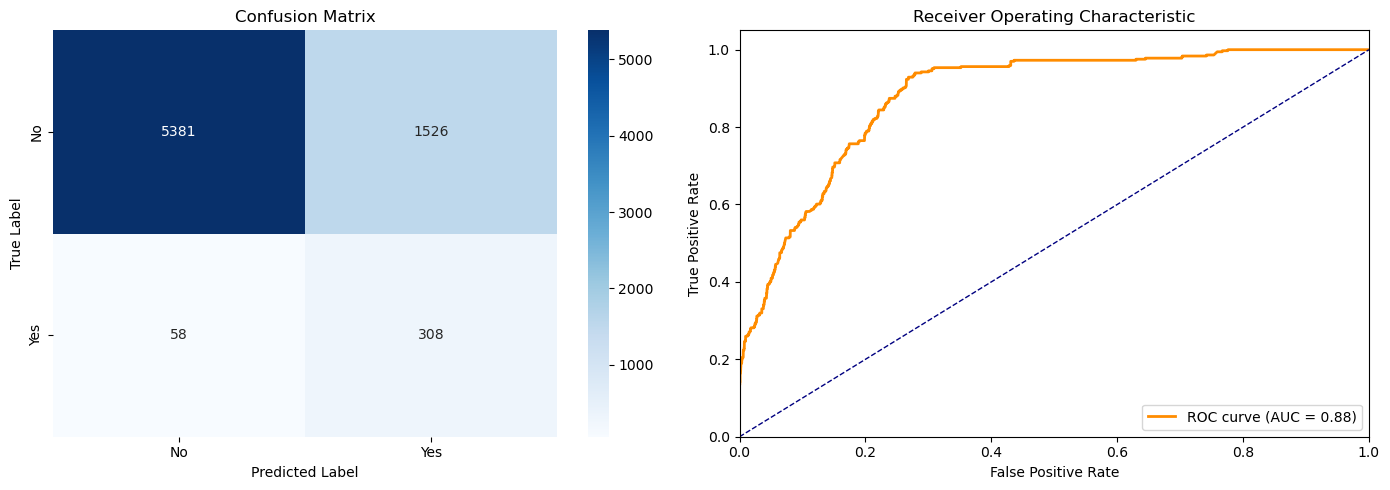

Cross-validated F1 scores: [0.28051487 0.27533784 0.27036705 0.27186964 0.27552385]
Mean F1: 0.27472265065799817


In [322]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('oversampler', RandomOverSampler(random_state=42)),  
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = rf_pipeline.predict(X_val)
y_proba = rf_pipeline.predict_proba(X_val)[:, 1]

# Evaluate
print(classification_report(y_val, y_pred))
plot_classification_results(y_val, y_pred, y_proba, labels=["No", "Yes"])
cross_validation(rf_pipeline, X_train_full, y_train_full)

#### Evaluate the model on the test set

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      7528
           1       0.46      0.50      0.48       802

    accuracy                           0.90      8330
   macro avg       0.70      0.72      0.71      8330
weighted avg       0.90      0.90      0.90      8330



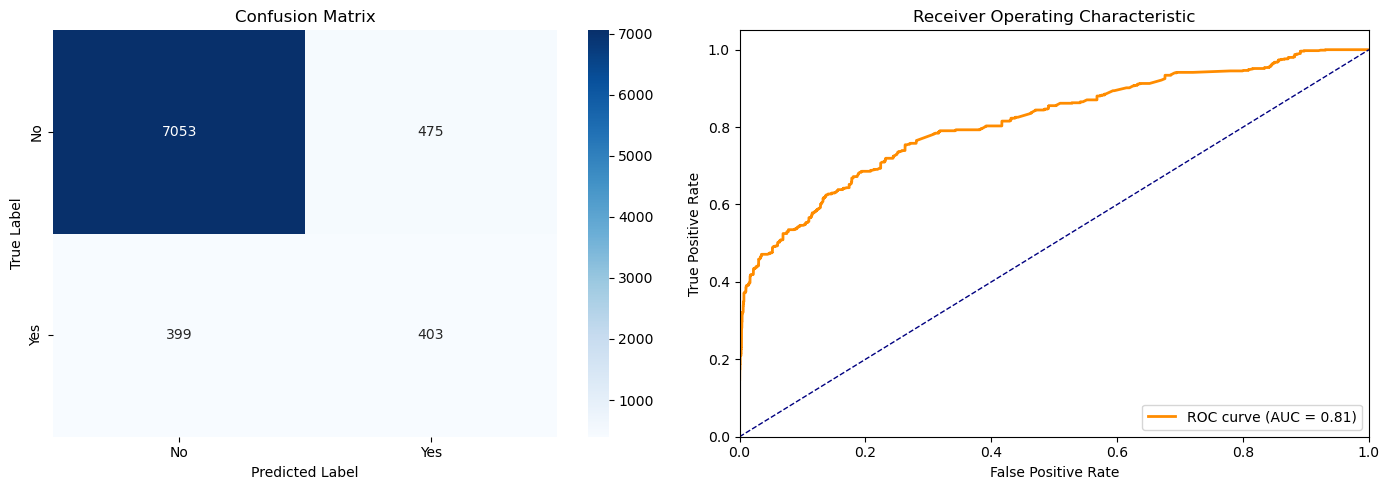

Cross-validated F1 scores: [0.28051487 0.27533784 0.27036705 0.27186964 0.27552385]
Mean F1: 0.27472265065799817


In [323]:
# Predict on test
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
plot_classification_results(y_test, y_pred, y_proba, labels=["No", "Yes"])
cross_validation(rf_pipeline, X_train_full, y_train_full)

The resulting model seems to underfit the data, despite using a high maximum depth for the trees, resulting in a high number of both false positives and false negatives.

---

### 4. Gradient Boosting

---

For this particular case we will directly use oversampling

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      6907
           1       0.30      0.97      0.45       366

    accuracy                           0.88      7273
   macro avg       0.65      0.92      0.69      7273
weighted avg       0.96      0.88      0.91      7273



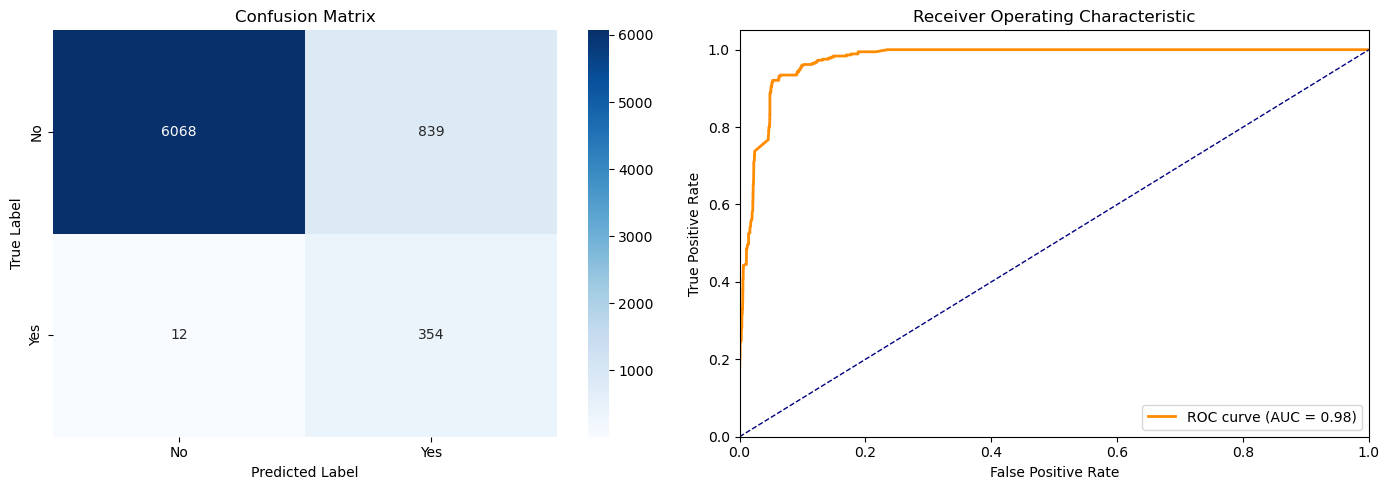

Cross-validated F1 scores: [0.28051487 0.27533784 0.27036705 0.27186964 0.27552385]
Mean F1: 0.27472265065799817


In [327]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversampler', RandomOverSampler(random_state=42)),  
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42))
])

# Fit the model
gb_pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = gb_pipeline.predict(X_val)
y_proba = gb_pipeline.predict_proba(X_val)[:, 1]

# Evaluate
print(classification_report(y_val, y_pred))
plot_classification_results(y_val, y_pred, y_proba, labels=["No", "Yes"])
cross_validation(rf_pipeline, X_train_full, y_train_full)

#### Evaluate the model on the test set:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      7528
           1       0.00      0.00      0.00       802

    accuracy                           0.90      8330
   macro avg       0.45      0.50      0.47      8330
weighted avg       0.82      0.90      0.86      8330



/Users/queralt/anaconda3/envs/synthesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/queralt/anaconda3/envs/synthesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/queralt/anaconda3/envs/synthesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

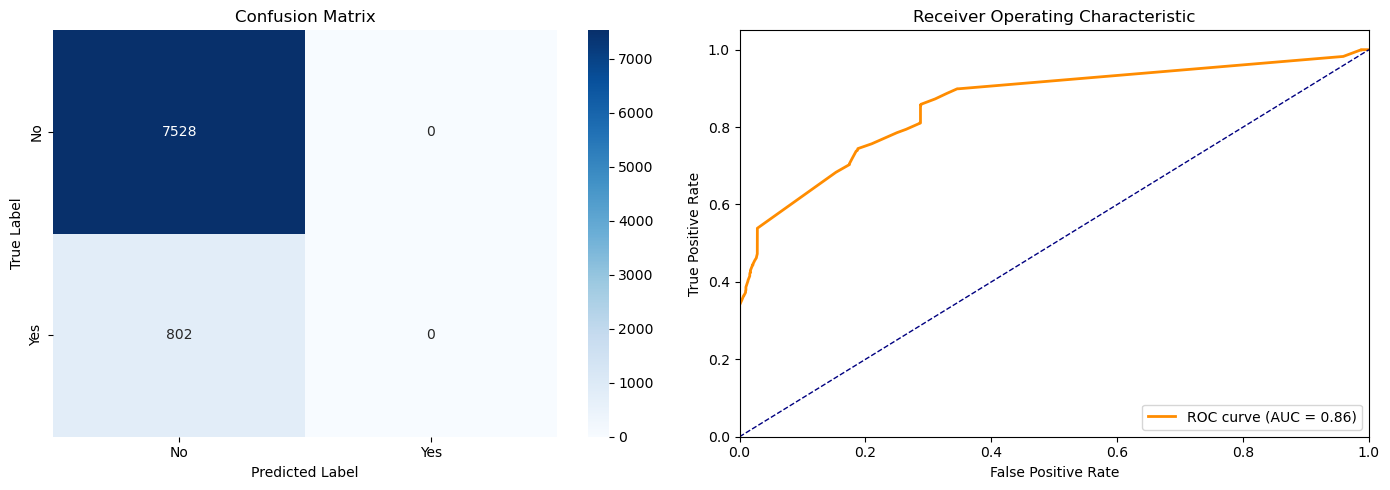

Cross-validated F1 scores: [0.28051487 0.27533784 0.27036705 0.27186964 0.27552385]
Mean F1: 0.27472265065799817


In [328]:
# Make predictions on the test set
y_pred = gb_pipeline.predict(X_test)
y_proba = gb_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
plot_classification_results(y_test, y_pred, y_proba, labels=["No", "Yes"])
cross_validation(rf_pipeline, X_train_full, y_train_full)

After trying it, we can see that gradient boosting is not the best option. It seems to overfit the data by learning the most common pattern, which is always predicting 0.